In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import numpy as np
from sklearn.metrics import recall_score, precision_score

%matplotlib inline

In [ ]:
df_train = pd.read_csv("/content/train_dataset_train.csv")

## Рассмотрим датасет по ближе

In [ ]:
df_train.shape

(4222094, 6)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4222094 entries, 0 to 4222093
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   Easting      float64
 2   Northing     float64
 3   Height       float64
 4   Reflectance  float64
 5   Class        int64  
dtypes: float64(4), int64(2)
memory usage: 193.3 MB


Пострим на распределение данных

Text(0.5, 1.0, 'Распределение класса точки')

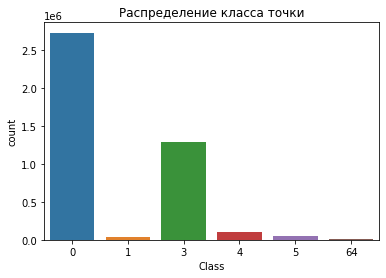

In [ ]:
sns.countplot(x = "Class" , data  = df_train).set_title('Распределение класса точки')

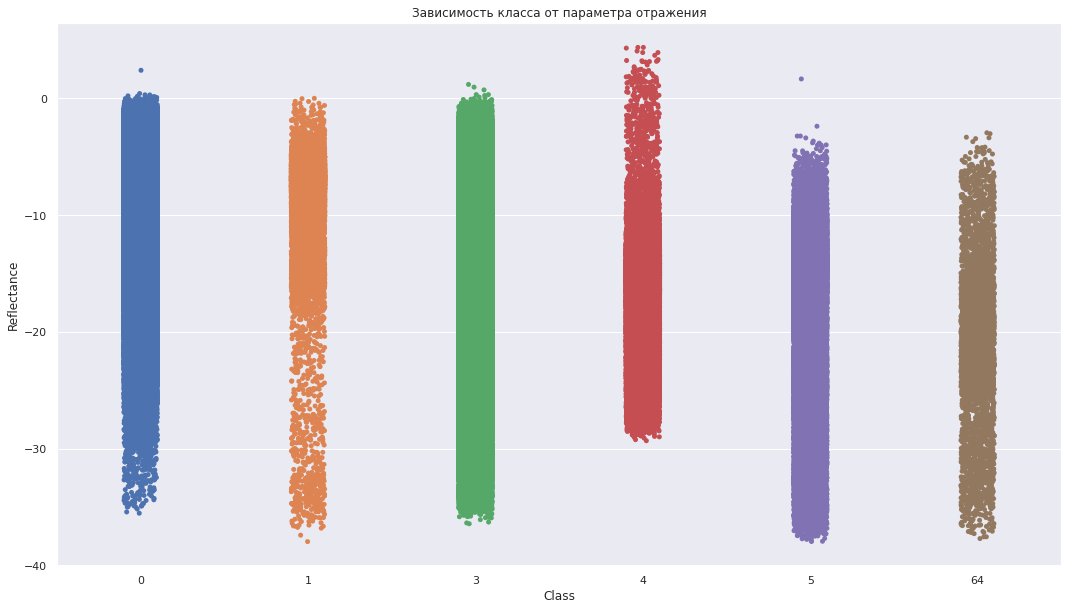

In [ ]:
sns.set(rc={'figure.figsize':(18,10)})
sns.stripplot(data = df_train, x= "Class", y = "Reflectance").set_title('Зависимость класса от параметра отражения');

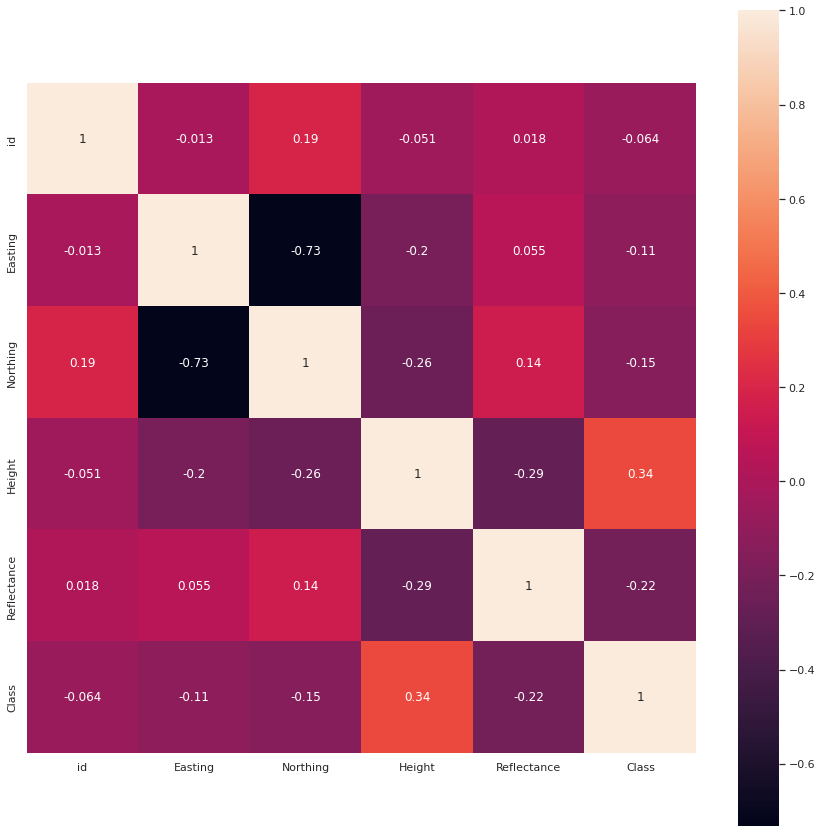

In [ ]:
plt.rcParams['figure.figsize']=(15,15)

g = sns.heatmap(df_train.corr(), square = True, annot=True)

## Выделим выборки

In [ ]:
df_train = df_train.fillna(0)

In [ ]:
X = df_train.drop(["Class", "id"], axis = 1)
y = df_train[["Class"]]

In [ ]:
X.shape

(4222094, 4)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
y_train

,Class
408665,0
1215009,3
568376,0
33256,3
2742206,3
...,...
4044887,0
1136074,3
1570006,3
2234489,0


## Вспомогательные функции

In [ ]:
# Функция получения x_data и y_data
##['id', 'Easting', 'Northing', 'Height', 'Reflectance', 'Class', 'AnglePlane', 'Anglex', 'Angley', 'Distance', 'Direction', 'Corner', 'NormReflectance']
def split_data(initial_data, only_x = False):
  #var = initial_data.reset_index().values
  x_data = initial_data[['Easting', 'Northing', 'Height', 'Reflectance', 'AnglePlane', 'Anglex', 'Angley', 'Distance', 'Direction', 'Corner', 'NormReflectance']].values
  if only_x:
     print('Размерность x_data -', x_data.shape)
     print()
     return x_data
  else:
    y_data = initial_data[['Class']].values
    print('Размерность x_data -', x_data.shape)
    print('Размерность y_data -', y_data.shape)
    print()
    return x_data, y_data

In [ ]:
# Функция для перевода в one hot encoding
# y_data2 = utils.to_categorical(y_data, 3)
# arr_unique_values = [80, 4, 2]
def categories (y_data, arr_unique_values = [0, 1, 3, 4, 5, 64]):
  result = []
  for y in y_data:
    if y == arr_unique_values[0]:
      result.append([1, 0, 0, 0, 0, 0])
    elif y == arr_unique_values[1]:
      result.append([0, 1, 0, 0, 0, 0]) 
    elif y == arr_unique_values[2]:
      result.append([0, 0, 1, 0, 0, 0])
    elif y == arr_unique_values[3]:
      result.append([0, 0, 0, 1, 0, 0])
    elif y == arr_unique_values[4]:
      result.append([0, 0, 0, 1, 0, 0]) 
    elif y == arr_unique_values[5]:
      result.append([0, 0, 0, 0, 1, 0])   
    else:
      result.append([0, 0, 0, 0, 0, 1]) 
  return result

## Подготовка данных

### Пересоберем датасет и выровним количество данных каждого класса

Text(0.5, 1.0, 'Распределение класса точки')

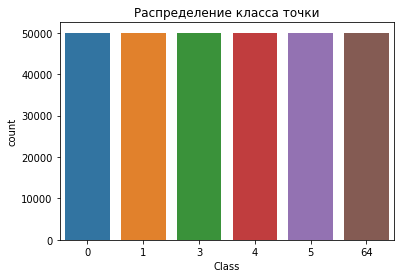

In [ ]:
arr_unique_values = [0, 1, 3, 4, 5, 64]
data_set = df_train[0:1].copy()
number_records_class = 50000
for CurrentClass in arr_unique_values:
  temp = df_train[df_train['Class'] == CurrentClass]
  temp2 = temp.sample(number_records_class, replace = True)
  data_set = pd.concat([data_set, temp2])
  
sns.countplot(x = "Class" , data  = data_set).set_title('Распределение класса точки')

### Расширение

In [ ]:
#['Easting', 'Northing', 'Height', 'Reflectance', 'Class', 'AnglePlane', 'Anglex', 'Angley', 'Distance', 'Direction', 'Corner', 'NormReflectance']
def preparation_data(initial_data):
  minimum = initial_data.min()
  df = initial_data.copy()
  df = df.assign(AnglePlane = (df.Easting/df.Northing))
  df = df.assign(Anglex = (df.Easting/df.Height))
  df = df.assign(Angley = (df.Easting/df.Height))
  df = df.assign(Distance = (df.Easting**2 + df.Northing**2 + df.Height**2)**0.5) 
  df = df.assign(Direction = (df.Easting**2 + df.Northing**2)**0.5) 
  df = df.assign(Corner = df.Height/df.Direction)
  df = df.assign(NormReflectance = df.Reflectance/df.Distance)
  df['Easting'] -= minimum.Easting 
  df['Northing'] -= minimum.Northing   
  df['Height'] -= minimum.Height
  return df

In [ ]:
#df1 = preparation_data(df_train)
df1 = preparation_data(data_set)
df1.describe()


,id,Easting,Northing,Height,Reflectance,Class,AnglePlane,Anglex,Angley,Distance,Direction,Corner,NormReflectance
count,3.000010e+05,300001.000000,300001.000000,300001.000000,300001.000000,300001.000000,300001.000000,300001.000000,300001.000000,3.000010e+05,3.000010e+05,3.000010e+05,3.000010e+05
mean,3.015291e+06,74.810570,73.621920,11.239078,-14.021904,12.833291,0.071565,6039.208775,6039.208775,6.047733e+06,6.047733e+06,1.184799e-05,-2.318539e-06
std,1.727158e+06,31.369399,31.325649,3.603057,6.803863,22.944994,0.000005,286.746307,286.746307,2.965262e+01,2.965262e+01,5.957709e-07,1.125028e-06
min,1.259000e+03,0.000000,0.000000,0.000000,-37.930000,0.000000,0.071553,3228.706591,3228.706591,6.047661e+06,6.047661e+06,9.989521e-06,-6.271801e-06
25%,1.476643e+06,46.924300,46.317400,8.820500,-18.010000,1.000000,0.071561,5763.749830,5763.749830,6.047708e+06,6.047708e+06,1.144808e-05,-2.977985e-06
50%,2.954417e+06,75.455500,75.452000,9.566100,-13.340000,3.000000,0.071565,6168.445766,6168.445766,6.047735e+06,6.047735e+06,1.157143e-05,-2.205770e-06
75%,4.446702e+06,99.622100,98.084600,14.486900,-8.420000,5.000000,0.071570,6235.405535,6235.405535,6.047756e+06,6.047756e+06,1.238504e-05,-1.392257e-06
max,6.032615e+06,150.239000,151.878100,73.304100,4.360000,64.000000,0.071578,7145.064524,7145.064524,6.047810e+06,6.047810e+06,2.211048e-05,7.209317e-07


In [ ]:
df1.head()

,id,Easting,Northing,Height,Reflectance,Class,AnglePlane,Anglex,Angley,Distance,Direction,Corner,NormReflectance
0,2321251,66.9026,87.7249,8.8082,-11.14,0,0.071564,6236.352542,6236.352542,6.047747e+06,6.047747e+06,0.000011,-0.000002
4186187,5555687,96.4676,65.9607,8.7969,-7.99,0,0.071569,6237.797910,6237.797910,6.047727e+06,6.047727e+06,0.000011,-0.000001
1930522,1421088,34.7214,120.8383,8.8025,-6.80,0,0.071558,6236.401172,6236.401172,6.047777e+06,6.047777e+06,0.000011,-0.000001
598185,5052195,131.4986,39.9616,7.5404,-11.06,0,0.071575,6353.651744,6353.651744,6.047704e+06,6.047704e+06,0.000011,-0.000002
1940926,167275,95.6951,76.8819,6.9304,-9.39,0,0.071569,6410.670609,6410.670609,6.047738e+06,6.047738e+06,0.000011,-0.000002


In [ ]:
#x, y = split_data(data_set)
x, y = split_data(df1)

Размерность x_data - (300001, 11)
Размерность y_data - (300001, 1)



In [ ]:
print(x[0])
print(y[0])

[ 6.69026000e+01  8.77249000e+01  8.80820000e+00 -1.11400000e+01
  7.15639382e-02  6.23635254e+03  6.23635254e+03  6.04774670e+06
  6.04774670e+06  1.14460151e-05 -1.84200836e-06]
[0]


In [ ]:
from sklearn import preprocessing
x1 = preprocessing.normalize(x, axis = 0)
print(*x[0])
print(*x1[0])

66.90259999997215 87.72489999979734 8.8082 -11.14 0.07156393815319174 6236.352542377778 6236.352542377778 6047746.695939587 6047746.695543426 1.1446015100303393e-05 -1.8420083644507324e-06
0.0015057296663163423 0.0020018029619321563 0.0013625487801435892 -0.001304982048842788 0.001825701097315609 0.0018832166017971465 0.0018832166017971465 0.0018257428916462683 0.0018257428916551232 0.0017615701453542504 -0.001304978620573264


In [ ]:
# Перевод в one hot encoding
x_data = x1 ## с нормализацией внешней
# x_data = x ## без нормализацией внешней
y_data = np.array(categories(y))
# Разбиение наборов на обучающую и проверочную выборки, тестовая выборка уже есть в задании
x_train, x_test1, y_train, y_test1 = train_test_split(x_data, 
                                                y_data, 
                                                test_size=0.2, 
                                                shuffle=True, 
                                                random_state = 42)
print('Размерность x_train -', x_train.shape)
print('Размерность y_train -', y_train.shape)
print('-----------------------------------------')
#print('Размерность x_test -', x_test1.shape)
#print('Размерность y_test -', y_test1.shape)

print(type(x_train))
print(type(y_train))
#print(type(x_test1))
#print(type(y_test1))

Размерность x_train - (240000, 11)
Размерность y_train - (240000, 6)
-----------------------------------------
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
x_val, x_test, y_val, y_test = train_test_split(x_test1, 
                                                y_test1, 
                                                test_size=0.8, 
                                                shuffle=True, 
                                                random_state = 25)
print('Размерность x_val -', x_val.shape)
print('Размерность y_val -', y_val.shape)
print('-----------------------------------------')
print('Размерность x_test -', x_test.shape)
print('Размерность y_test -', y_test.shape)

print(type(x_val))
print(type(y_val))
print(type(x_test))
print(type(y_test))

Размерность x_val - (12000, 11)
Размерность y_val - (12000, 6)
-----------------------------------------
Размерность x_test - (48001, 11)
Размерность y_test - (48001, 6)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
print('x_data пример:', x_data[0])
print('y_data пример:', *y_data[0])

x_data пример: [ 0.00150573  0.0020018   0.00136255 -0.00130498  0.0018257   0.00188322
  0.00188322  0.00182574  0.00182574  0.00176157 -0.00130498]
y_data пример: 1 0 0 0 0 0


In [ ]:
description_classes = ['точки земли', 'точки опор', 'точки растительности', 'точки рельсов', 'точки элементов контактной сети', 'точки шумов']
CLASS_COUNT = 6
epochs = 20
batch_size = 32

## Создание модели



In [ ]:
# Последовательная модель НС
from tensorflow.keras.models import Sequential      

# Основные слои
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization 

# Утилиты для to_categorical()
from tensorflow.keras import utils    

# Алгоритмы оптимизации для обучения модели
from tensorflow.keras.optimizers import Adam  

from tensorflow.keras.models import load_model



In [ ]:
x_train.shape[1]


11

In [ ]:
model = Sequential() # Последовательная модель нейронной сети

model.add(Dense(500, input_dim=x_train.shape[1], activation='relu'))
#model.add(BatchNormalization())
model.add(Dense(150, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(50, activation='relu'))
# model.add(Dropout(0.3))
model.add(Dense(CLASS_COUNT, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 500)               6000      
                                                                 
 dense_5 (Dense)             (None, 150)               75150     
                                                                 
 dropout_1 (Dropout)         (None, 150)               0         
                                                                 
 dense_6 (Dense)             (None, 50)                7550      
                                                                 
 dense_7 (Dense)             (None, 6)                 306       
                                                                 
Total params: 89,006
Trainable params: 89,006
Non-trainable params: 0
_________________________________________________________________


# Обучение модели

In [ ]:
# Компиляция модели
model.compile(optimizer=Adam(learning_rate=0.001), 
              metrics=['accuracy'], 
              loss='categorical_crossentropy')

In [ ]:
# Обучение модели
history = model.fit(x_train, 
                    y_train, 
                    validation_data=(x_test, 
                                     y_test), 
                    epochs = epochs, 
                    batch_size = batch_size) 

Epoch 1/20
7500/7500 [==============================] - 24s 3ms/step - loss: 1.1841 - accuracy: 0.4986 - val_loss: 0.8226 - val_accuracy: 0.7415
Epoch 2/20
7500/7500 [==============================] - 26s 4ms/step - loss: 0.7900 - accuracy: 0.7119 - val_loss: 0.6772 - val_accuracy: 0.7739
Epoch 3/20
7500/7500 [==============================] - 27s 4ms/step - loss: 0.6703 - accuracy: 0.7617 - val_loss: 0.5359 - val_accuracy: 0.8216
Epoch 4/20
7500/7500 [==============================] - 27s 4ms/step - loss: 0.5674 - accuracy: 0.7974 - val_loss: 0.4683 - val_accuracy: 0.8430
Epoch 5/20
7500/7500 [==============================] - 24s 3ms/step - loss: 0.5202 - accuracy: 0.8116 - val_loss: 0.4495 - val_accuracy: 0.8490
Epoch 6/20
7500/7500 [==============================] - 21s 3ms/step - loss: 0.4980 - accuracy: 0.8211 - val_loss: 0.4279 - val_accuracy: 0.8558
Epoch 7/20
7500/7500 [==============================] - 25s 3ms/step - loss: 0.4749 - accuracy: 0.8291 - val_loss: 0.4089 - val_ac

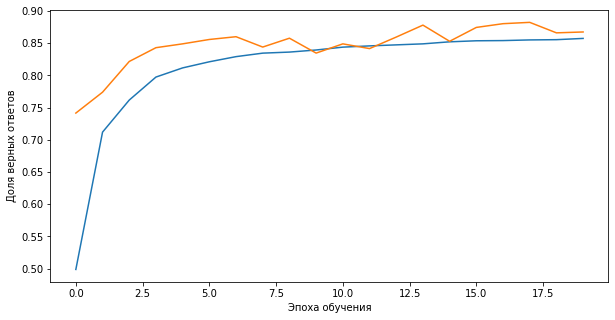

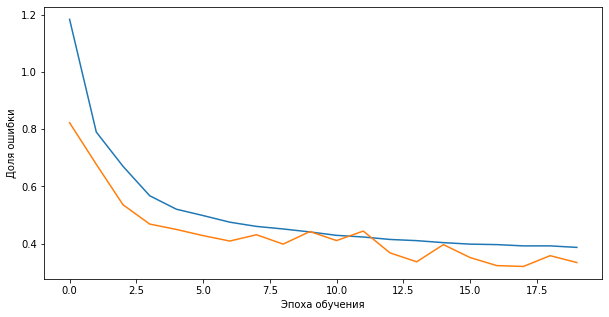

In [ ]:
# Вывод графика обучения (точность)
plt.rcParams['figure.figsize']=(10,5)
plt.plot(history.history['accuracy'], label ='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'] , label ='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.show()

# Вывод графика обучения (доля ошибки)

plt.plot(history.history['loss'], label ='Доля ошибки ответов на обучающем наборе')
plt.plot(history.history['val_loss'], label ='Доля ошибки ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля ошибки')
plt.show()  

In [ ]:
# сохранение обученной модели веса и архитектура
model.save('model_test_1.h5')

In [ ]:
# Загрузка модели, если это необходимо
model = load_model('model_test_1.h5')

In [ ]:
# Дообучим модель 
model.compile(optimizer=Adam(learning_rate=0.00001), 
              metrics=['accuracy'], 
              loss='categorical_crossentropy')

In [ ]:
# Обучение модели
history = model.fit(x_train, 
                    y_train, 
                    validation_data=(x_test, 
                                     y_test), 
                    epochs = epochs, 
                    batch_size = batch_size) 

Epoch 1/20
7500/7500 [==============================] - 25s 3ms/step - loss: 0.3316 - accuracy: 0.8764 - val_loss: 0.3018 - val_accuracy: 0.8874
Epoch 2/20
7500/7500 [==============================] - 24s 3ms/step - loss: 0.3273 - accuracy: 0.8791 - val_loss: 0.2992 - val_accuracy: 0.8879
Epoch 3/20
7500/7500 [==============================] - 21s 3ms/step - loss: 0.3256 - accuracy: 0.8800 - val_loss: 0.2962 - val_accuracy: 0.8886
Epoch 4/20
7500/7500 [==============================] - 24s 3ms/step - loss: 0.3250 - accuracy: 0.8801 - val_loss: 0.2964 - val_accuracy: 0.8894
Epoch 5/20
7500/7500 [==============================] - 21s 3ms/step - loss: 0.3236 - accuracy: 0.8806 - val_loss: 0.2968 - val_accuracy: 0.8877
Epoch 6/20
7500/7500 [==============================] - 24s 3ms/step - loss: 0.3236 - accuracy: 0.8799 - val_loss: 0.2934 - val_accuracy: 0.8898
Epoch 7/20
7500/7500 [==============================] - 21s 3ms/step - loss: 0.3228 - accuracy: 0.8804 - val_loss: 0.2933 - val_ac

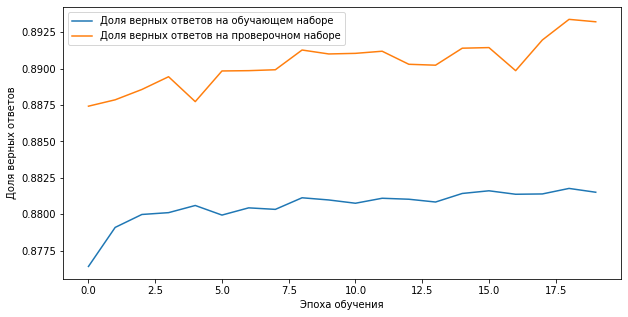

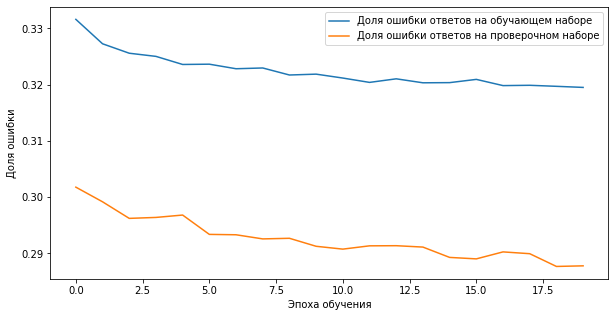

In [ ]:
# Вывод графика обучения (точность)
plt.rcParams['figure.figsize']=(10,5)
plt.plot(history.history['accuracy'], label ='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'] , label ='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

# Вывод графика обучения (доля ошибки)

plt.plot(history.history['loss'], label ='Доля ошибки ответов на обучающем наборе')
plt.plot(history.history['val_loss'], label ='Доля ошибки ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля ошибки')
plt.legend()
plt.show()  

In [ ]:
# сохранение обученной модели веса и архитектура
model.save('model_test_2.h5')

In [ ]:
# Загрузка модели, если это необходимо
model = load_model('/content/model_test_2 (1).h5')

## Тестирование данных на валидационной выборке

In [ ]:
print('x_val пример:', *x_val[0])
print('y_val пример:', *y_val[0])

x_val пример: 0.0007660625246728279 0.0027332166175514662 0.002778342183493443 -0.0013752683351359364 0.0018255524072929483 0.001663173527180598 0.001663173527180598 0.001825751835144637 0.0018257518351197774 0.0019944697806609482 -0.0013752579854457712
y_val пример: 0 0 0 1 0 0


In [ ]:
x_val.shape[1]

11

In [ ]:
model.evaluate(x_val, y_val)
#model.evaluate(x_test, y_test)

375/375 [==============================] - 1s 2ms/step - loss: 0.2612 - accuracy: 0.9011


[0.2612103819847107, 0.9010833501815796]

In [ ]:
# Предсказание модели
predictions = np.argmax(model.predict(x_val), axis=1)
y_test_nums = np.argmax(y_val, axis=1)
# Вывод результатов тестирования
for i in range(100):
#for i in range(len(x_val)):
    print(f'Предсказано - {predictions[i]}, было {y_test_nums[i]}, {predictions[i] == y_test_nums[i]}')
print(f'\n Процент верных предсказаний - {(predictions == y_test_nums).mean()*100} %')


Предсказано - 3, было 3, True
Предсказано - 4, было 4, True
Предсказано - 3, было 3, True
Предсказано - 2, было 4, False
Предсказано - 3, было 1, False
Предсказано - 3, было 3, True
Предсказано - 0, было 0, True
Предсказано - 4, было 4, True
Предсказано - 3, было 3, True
Предсказано - 1, было 1, True
Предсказано - 4, было 4, True
Предсказано - 1, было 4, False
Предсказано - 3, было 3, True
Предсказано - 3, было 3, True
Предсказано - 4, было 4, True
Предсказано - 3, было 3, True
Предсказано - 3, было 3, True
Предсказано - 1, было 1, True
Предсказано - 3, было 3, True
Предсказано - 3, было 0, False
Предсказано - 0, было 0, True
Предсказано - 2, было 2, True
Предсказано - 3, было 3, True
Предсказано - 3, было 3, True
Предсказано - 0, было 0, True
Предсказано - 4, было 4, True
Предсказано - 3, было 3, True
Предсказано - 3, было 3, True
Предсказано - 1, было 1, True
Предсказано - 3, было 3, True
Предсказано - 4, было 4, True
Предсказано - 0, было 0, True
Предсказано - 4, было 4, True
Предск

## Тестирование данных на тестовой выборке

In [ ]:
df_test = pd.read_csv("/content/test_dataset_test.csv")

In [ ]:
df_test.head(10)

,id,Easting,Northing,Height,Reflectance
0,1836965,431754.6192,6.032265e+06,69.2608,-13.99
1,3659389,431654.4141,6.032344e+06,68.0129,-10.99
2,5433033,431686.8574,6.032334e+06,69.2442,-10.26
3,1168709,431711.5747,6.032293e+06,69.6617,-8.25
4,5821779,431728.5806,6.032315e+06,67.6753,-7.56
5,3620811,431649.6226,6.032326e+06,72.9469,-8.94
6,3586468,431710.2029,6.032309e+06,69.2483,-8.06
7,4970706,431757.5999,6.032269e+06,69.2540,-9.57
8,4250983,431728.1014,6.032299e+06,69.1775,-7.66
9,1819191,431737.6539,6.032279e+06,69.1754,-9.69


In [ ]:
df_test_extended = preparation_data(df_test)
df_test_extended.describe()

,id,Easting,Northing,Height,Reflectance,AnglePlane,Anglex,Angley,Distance,Direction,Corner,NormReflectance
count,1.809469e+06,1.809469e+06,1.809469e+06,1.809469e+06,1.809469e+06,1.809469e+06,1.809469e+06,1.809469e+06,1.809469e+06,1.809469e+06,1.809469e+06,1.809469e+06
mean,3.017115e+06,7.715673e+01,7.617407e+01,8.818415e+00,-1.053247e+01,7.156578e-02,6.226657e+03,6.226657e+03,6.047736e+06,6.047736e+06,1.147572e-05,-1.741556e-06
std,1.740939e+06,2.978739e+01,2.981733e+01,2.269805e+00,4.523283e+00,5.202625e-06,1.924581e+02,1.924581e+02,2.822117e+01,2.822118e+01,3.753310e-07,7.479317e-07
min,1.205000e+03,0.000000e+00,0.000000e+00,0.000000e+00,-3.770000e+01,7.155275e-02,3.727328e+03,3.727328e+03,6.047661e+06,6.047661e+06,1.001751e-05,-6.233735e-06
25%,1.508726e+06,5.289370e+01,5.207700e+01,7.208400e+00,-1.263000e+01,7.156149e-02,6.229782e+03,6.229782e+03,6.047713e+06,6.047713e+06,1.120949e-05,-2.088373e-06
50%,3.017950e+06,7.725840e+01,7.566600e+01,8.621300e+00,-9.940000e+00,7.156579e-02,6.238016e+03,6.238016e+03,6.047735e+06,6.047735e+06,1.144310e-05,-1.643587e-06
75%,4.524423e+06,1.011778e+02,1.005900e+02,8.715700e+00,-7.730000e+00,7.157003e-02,6.368113e+03,6.368113e+03,6.047759e+06,6.047759e+06,1.145874e-05,-1.278167e-06
max,6.032765e+06,1.516017e+02,1.521209e+02,5.523870e+01,3.040000e+00,7.157834e-02,7.125098e+03,7.125098e+03,6.047810e+06,6.047810e+06,1.915138e-05,5.026680e-07


In [ ]:
df_test_extended.head(10)

,id,Easting,Northing,Height,Reflectance,AnglePlane,Anglex,Angley,Distance,Direction,Corner,NormReflectance
0,1836965,124.9791,33.2956,8.6771,-13.99,0.071574,6233.751548,6233.751548,6.047696e+06,6.047696e+06,0.000011,-0.000002
1,3659389,24.7740,112.8503,7.4292,-10.99,0.071557,6346.655033,6346.655033,6.047769e+06,6.047769e+06,0.000011,-0.000002
2,5433033,57.2173,102.1582,8.6605,-10.26,0.071562,6234.267381,6234.267381,6.047760e+06,6.047760e+06,0.000011,-0.000002
3,1168709,81.9346,61.0896,9.0780,-8.25,0.071567,6197.258676,6197.258676,6.047721e+06,6.047721e+06,0.000012,-0.000001
4,5821779,98.9405,83.2491,7.0916,-7.56,0.071569,6379.411404,6379.411404,6.047744e+06,6.047744e+06,0.000011,-0.000001
5,3620811,19.9825,94.7242,12.3632,-8.94,0.071556,5917.312766,5917.312766,6.047750e+06,6.047750e+06,0.000012,-0.000001
6,3586468,80.5628,77.7268,8.6646,-8.06,0.071566,6234.235395,6234.235395,6.047737e+06,6.047737e+06,0.000011,-0.000001
7,4970706,127.9598,37.8383,8.6703,-9.57,0.071575,6234.406675,6234.406675,6.047701e+06,6.047701e+06,0.000011,-0.000002
8,4250983,98.4613,67.1039,8.5938,-7.66,0.071569,6240.874582,6240.874582,6.047728e+06,6.047728e+06,0.000011,-0.000001
9,1819191,108.0138,46.9930,8.5917,-9.69,0.071571,6241.202131,6241.202131,6.047709e+06,6.047709e+06,0.000011,-0.000002


In [ ]:
x = split_data(df_test_extended, only_x = True)

Размерность x_data - (1809469, 11)



In [ ]:
print('x_val пример:', *x[0])

x_val пример: 124.97909999999683 33.29559999983758 8.677100000000003 -13.99 0.07157421509027466 6233.751547773055 6233.751547773055 6047696.324134428 6047696.323737826 1.1452426889912491e-05 -2.313277527538936e-06


In [ ]:
# Предсказание модели
predictions = np.argmax(model.predict(x), axis=1)

In [ ]:
arr_unique_values = [0, 1, 3, 4, 5, 64]
# Вывод результатов тестирования
Forecast_Result = []
#for i in range(100):
for i in range(len(x)):
    #print(f'{predictions[i]} - Предсказано - {arr_unique_values[predictions[i]]}')
    Forecast_Result.append(arr_unique_values[predictions[i]])


In [ ]:
df_test_extended["Result"] = Forecast_Result

In [ ]:
df_test_extended.describe()

,id,Easting,Northing,Height,Reflectance,AnglePlane,Anglex,Angley,Distance,Direction,Corner,NormReflectance,Result
count,1.809469e+06,1.809469e+06,1.809469e+06,1.809469e+06,1.809469e+06,1.809469e+06,1.809469e+06,1.809469e+06,1.809469e+06,1.809469e+06,1.809469e+06,1.809469e+06,1809469.0
mean,3.017115e+06,7.715673e+01,7.617407e+01,8.818415e+00,-1.053247e+01,7.156578e-02,6.226657e+03,6.226657e+03,6.047736e+06,6.047736e+06,1.147572e-05,-1.741556e-06,5.0
std,1.740939e+06,2.978739e+01,2.981733e+01,2.269805e+00,4.523283e+00,5.202625e-06,1.924581e+02,1.924581e+02,2.822117e+01,2.822118e+01,3.753310e-07,7.479317e-07,0.0
min,1.205000e+03,0.000000e+00,0.000000e+00,0.000000e+00,-3.770000e+01,7.155275e-02,3.727328e+03,3.727328e+03,6.047661e+06,6.047661e+06,1.001751e-05,-6.233735e-06,5.0
25%,1.508726e+06,5.289370e+01,5.207700e+01,7.208400e+00,-1.263000e+01,7.156149e-02,6.229782e+03,6.229782e+03,6.047713e+06,6.047713e+06,1.120949e-05,-2.088373e-06,5.0
50%,3.017950e+06,7.725840e+01,7.566600e+01,8.621300e+00,-9.940000e+00,7.156579e-02,6.238016e+03,6.238016e+03,6.047735e+06,6.047735e+06,1.144310e-05,-1.643587e-06,5.0
75%,4.524423e+06,1.011778e+02,1.005900e+02,8.715700e+00,-7.730000e+00,7.157003e-02,6.368113e+03,6.368113e+03,6.047759e+06,6.047759e+06,1.145874e-05,-1.278167e-06,5.0
max,6.032765e+06,1.516017e+02,1.521209e+02,5.523870e+01,3.040000e+00,7.157834e-02,7.125098e+03,7.125098e+03,6.047810e+06,6.047810e+06,1.915138e-05,5.026680e-07,5.0


In [ ]:
df_test_extended.head(10)

,id,Easting,Northing,Height,Reflectance,AnglePlane,Anglex,Angley,Distance,Direction,Corner,NormReflectance,Result
0,1836965,124.9791,33.2956,8.6771,-13.99,0.071574,6233.751548,6233.751548,6.047696e+06,6.047696e+06,0.000011,-0.000002,5
1,3659389,24.7740,112.8503,7.4292,-10.99,0.071557,6346.655033,6346.655033,6.047769e+06,6.047769e+06,0.000011,-0.000002,5
2,5433033,57.2173,102.1582,8.6605,-10.26,0.071562,6234.267381,6234.267381,6.047760e+06,6.047760e+06,0.000011,-0.000002,5
3,1168709,81.9346,61.0896,9.0780,-8.25,0.071567,6197.258676,6197.258676,6.047721e+06,6.047721e+06,0.000012,-0.000001,5
4,5821779,98.9405,83.2491,7.0916,-7.56,0.071569,6379.411404,6379.411404,6.047744e+06,6.047744e+06,0.000011,-0.000001,5
5,3620811,19.9825,94.7242,12.3632,-8.94,0.071556,5917.312766,5917.312766,6.047750e+06,6.047750e+06,0.000012,-0.000001,5
6,3586468,80.5628,77.7268,8.6646,-8.06,0.071566,6234.235395,6234.235395,6.047737e+06,6.047737e+06,0.000011,-0.000001,5
7,4970706,127.9598,37.8383,8.6703,-9.57,0.071575,6234.406675,6234.406675,6.047701e+06,6.047701e+06,0.000011,-0.000002,5
8,4250983,98.4613,67.1039,8.5938,-7.66,0.071569,6240.874582,6240.874582,6.047728e+06,6.047728e+06,0.000011,-0.000001,5
9,1819191,108.0138,46.9930,8.5917,-9.69,0.071571,6241.202131,6241.202131,6.047709e+06,6.047709e+06,0.000011,-0.000002,5


In [ ]:
df_test_extended.tail(10)

,id,Easting,Northing,Height,Reflectance,AnglePlane,Anglex,Angley,Distance,Direction,Corner,NormReflectance,Result
1809459,4232578,83.1380,75.8622,8.7008,-8.01,0.071567,6231.015279,6231.015279,6.047736e+06,6.047736e+06,0.000011,-1.324463e-06,5
1809460,5281884,39.4272,102.5163,9.2037,-10.50,0.071559,6185.487170,6185.487170,6.047759e+06,6.047759e+06,0.000012,-1.736180e-06,5
1809461,1589368,104.4629,72.3821,6.7626,-6.91,0.071570,6410.658091,6410.658091,6.047734e+06,6.047734e+06,0.000011,-1.142577e-06,5
1809462,342160,98.0418,23.7875,12.2228,-11.47,0.071570,5929.795855,5929.795855,6.047685e+06,6.047685e+06,0.000012,-1.896594e-06,5
1809463,4989769,123.3889,37.9087,8.6981,-9.85,0.071574,6231.839083,6231.839083,6.047701e+06,6.047701e+06,0.000011,-1.628718e-06,5
1809464,2279523,61.9945,94.0547,8.6232,-11.32,0.071563,6237.696452,6237.696452,6.047752e+06,6.047752e+06,0.000011,-1.871770e-06,5
1809465,220720,83.2013,106.7083,6.3105,-2.79,0.071566,6453.666258,6453.666258,6.047767e+06,6.047767e+06,0.000011,-4.613273e-07,5
1809466,3877535,65.5092,96.0615,8.6274,-4.83,0.071564,6237.368707,6237.368707,6.047755e+06,6.047755e+06,0.000011,-7.986435e-07,5
1809467,3389299,114.0439,43.6214,8.6473,-9.17,0.071572,6236.276870,6236.276870,6.047706e+06,6.047706e+06,0.000011,-1.516277e-06,5
1809468,447900,117.4679,23.0638,10.0132,-27.11,0.071573,6115.666665,6115.666665,6.047686e+06,6.047686e+06,0.000012,-4.482707e-06,5


In [ ]:
Result = df_test_extended[['id', 'Result']]

In [ ]:
Result.tail(10)

,id,Result
1809459,4232578,5
1809460,5281884,5
1809461,1589368,5
1809462,342160,5
1809463,4989769,5
1809464,2279523,5
1809465,220720,5
1809466,3877535,5
1809467,3389299,5
1809468,447900,5


In [ ]:
file_name = '/content/Result.csv'
Result.to_csv(file_name, encoding='utf-8', index=False)